In [10]:
import scanpy as sc
import numpy as np
from tqdm.notebook import tqdm
import os
import pandas as pd

from scipy.spatial import cKDTree
from scipy.stats import gaussian_kde

In [3]:
data_folder = '../../data'

In [4]:
ad_list = []
for adata_name in ['mock', '4hr_avr', '6hr_avr', '9hr_avr', 'avrrpt24']:
    ad_sp_only = sc.read(os.path.join(data_folder, 'integration', adata_name, 'spatial_data.h5ad'))
    ad_list.append(ad_sp_only)
ad_sp = sc.concat(ad_list)

In [5]:
ad_sp.X = ad_sp.layers['counts']

In [6]:
batches = np.unique(ad_sp.obs['batch'])
adata_list = []
for batch in batches:
    experiment = ad_sp[ad_sp.obs['batch']==batch, :]
    experiment.X = experiment.layers['counts']
    experiment.obs.index = batch + experiment.obs.index 
    experiment.obsm['X_spatial'] = experiment.obs[['x', 'y']].values
    adata_list.append(experiment.copy())

/home/amonell/mambaforge/envs/scdior/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


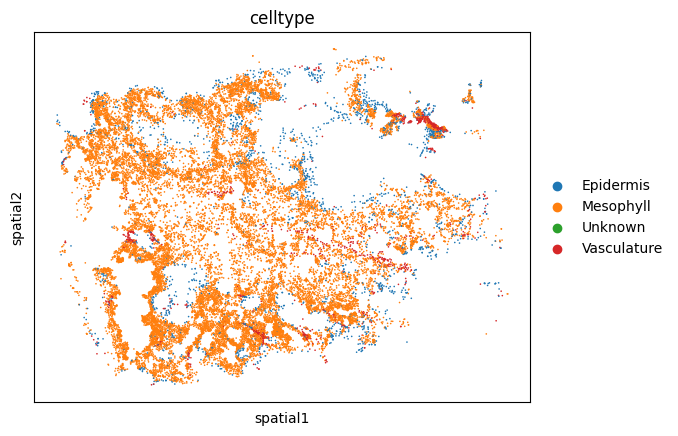

/home/amonell/mambaforge/envs/scdior/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


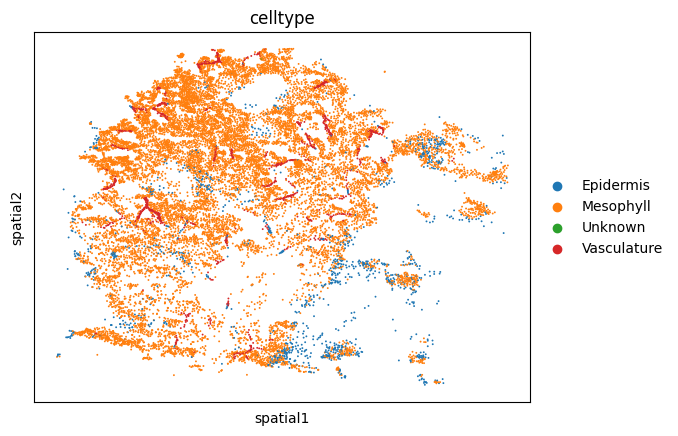

/home/amonell/mambaforge/envs/scdior/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


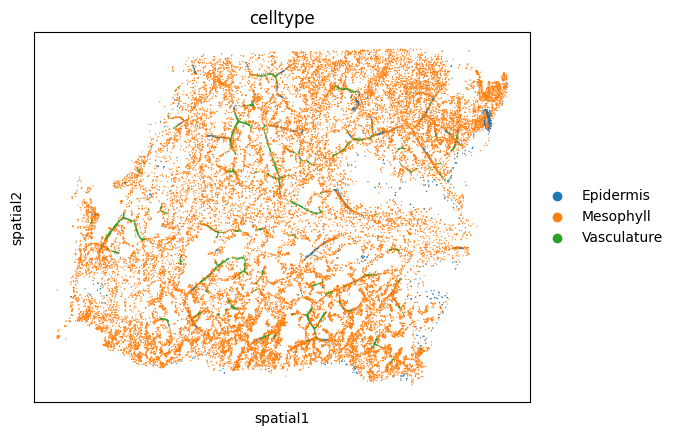

/home/amonell/mambaforge/envs/scdior/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


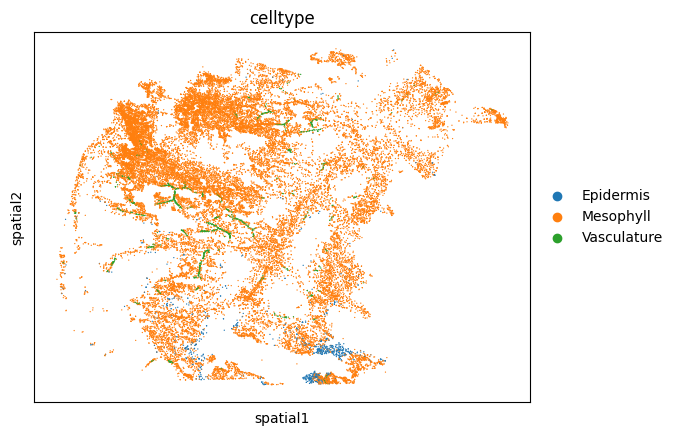

/home/amonell/mambaforge/envs/scdior/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


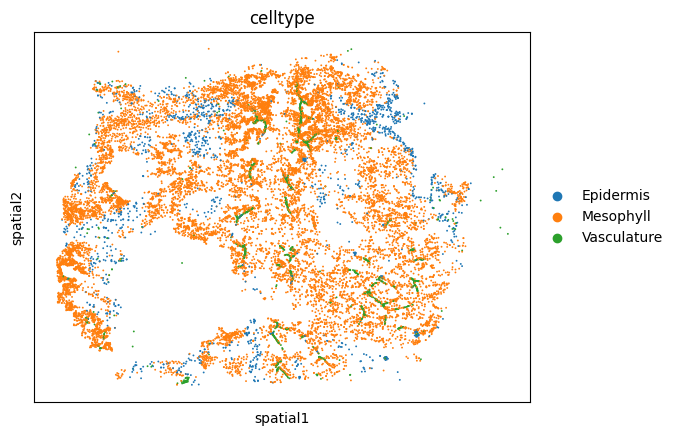

In [7]:
for a in adata_list:
    sc.pl.embedding(a, basis = 'spatial', color='celltype')

In [8]:
try:
    os.mkdir(os.path.join(data_folder, 'cside_preparations'))
except:
    print('Folder already made')

In [9]:
gene_symbols = pd.read_csv(os.path.join(data_folder, 'useful_files', 'geneID_to_geneName_MERSCOPE_panel1.txt'), sep='\t', index_col=0)
for k in range(len(adata_list)):
    adata = adata_list[k]
    adata.obs.index=adata.obs.index.str.replace('-', '_')
    if adata.obs.index.values[0][0].isnumeric():
        adata.obs.index= 'X'+np.array(adata.obs.index.values)
    filename = adata.obs.batch.values[0]
    try:
        os.mkdir(os.path.join(data_folder, 'cside_preparations', filename))
    except:
         print('Folder already made')
    # convert array into dataframe
    DF = pd.DataFrame(adata.X.A.T.astype(int), index=adata.var.index.values, columns=adata.obs.index.values)
     
    # save the dataframe as a csv file
    DF.to_csv(os.path.join(data_folder, 'cside_preparations', filename, 'counts.csv'))

    coords = pd.DataFrame(zip(adata.obs.index.values, adata.obs.x.values, adata.obs.y.values), columns=['barcodes', 'xcoord', 'ycoord'])
    coords.to_csv(os.path.join(data_folder, 'cside_preparations', filename, 'coords.csv'), index=None)

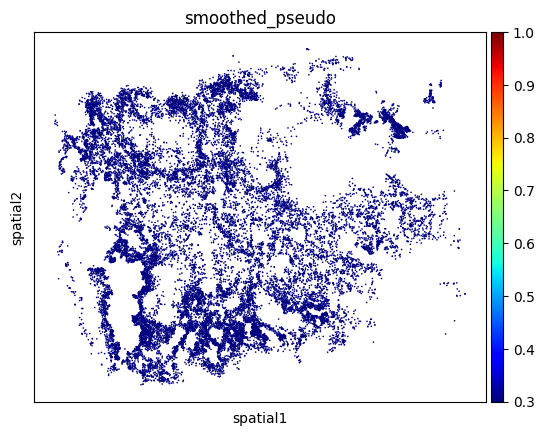

Folder already made


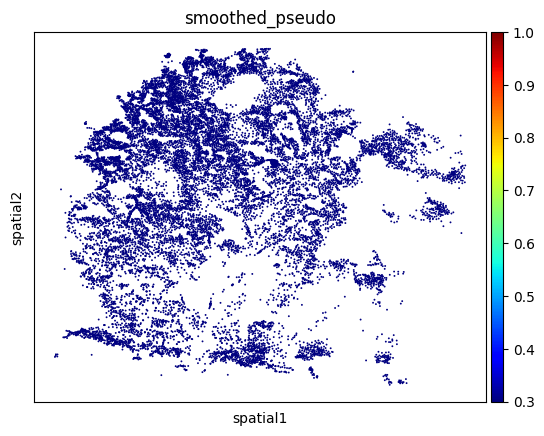

Folder already made


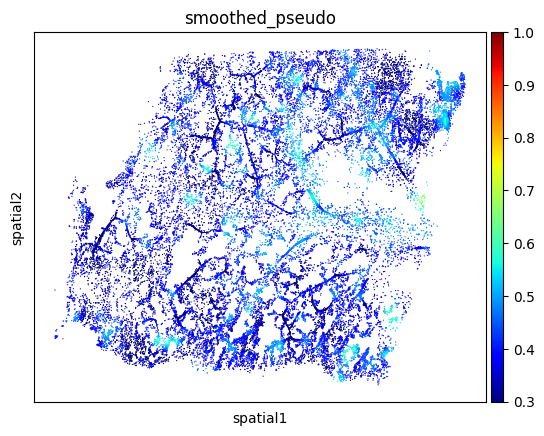

Folder already made


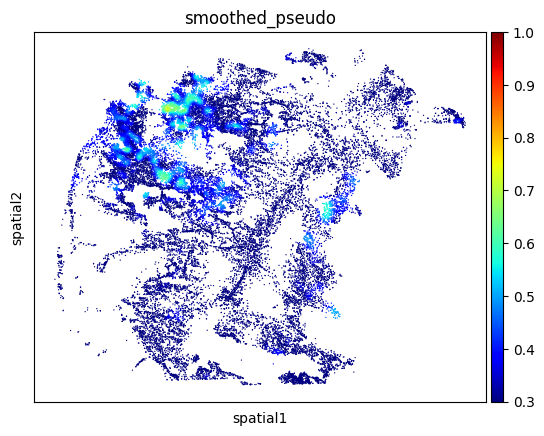

Folder already made


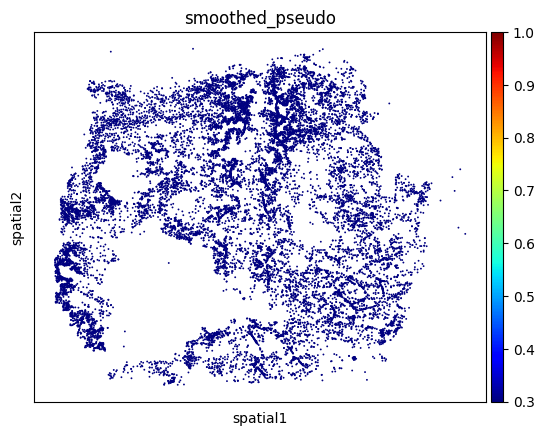

In [11]:


for k in range(len(adata_list)):
    adata = adata_list[k]
    adata.obs.index=adata.obs.index.str.replace('-', '_')
    if adata.obs.index.values[0][0].isnumeric():
        adata.obs.index= 'X'+np.array(adata.obs.index.values)

    # Sample data - Replace this with your data
    points = adata.obsm['X_spatial']
    values = adata.obs['pseudotime']
    categories = adata.obs['celltype']
    
    # Convert categories to a NumPy array for indexing
    categories = np.array(categories)
    
    # Create a KD-tree for efficient nearest neighbor search
    tree = cKDTree(points)
    
    # Define the number of nearest neighbors to consider
    n_neighbors = 50  # Change this value as needed
    
    # Function to calculate the smoothed value for each point
    def smooth_point(point_index):
        # Find the indices of the N nearest neighbors
        nearest_indices = tree.query(points[point_index], k=n_neighbors)[1]
        
        # Filter neighbors that belong to the 'Mesophyll' category
        mesophyll_neighbors = [i for i in nearest_indices if categories[i] == 'Mesophyll']
    
        # Calculate the weighted average of 'Mesophyll' values
        if mesophyll_neighbors:
            smoothed_value = np.mean(values[mesophyll_neighbors])
        else:
            # If no 'Mesophyll' neighbors are found, keep the original value
            smoothed_value = values[point_index]
    
        return smoothed_value
    
    # Apply the smoothing function to each point
    smoothed_values = [smooth_point(i) for i in range(len(points))]
    adata.obs['smoothed_pseudo'] = smoothed_values

    try:
        os.mkdir(os.path.join(data_folder, 'final_spatial_objects'))
    except:
        print('Folder already made')


    sc.pl.embedding(adata, basis='spatial', color='smoothed_pseudo', vmax=1, cmap='jet', vmin=0.3)


    filename = adata.obs.batch.values[0]

    adata.write(os.path.join(data_folder, 'final_spatial_objects', f'{filename}.h5ad'))

    pd.DataFrame(adata.obs.smoothed_pseudo.values, index=adata.obs.index.values, columns=['Smoothed']).to_csv(os.path.join(data_folder, 'cside_preparations', filename, 'axis.csv'))


## Writing scrnaseq mat

In [13]:
adata = sc.read(os.path.join(data_folder, 'temp_objects', 'seq_reference_00.h5ad'))

In [14]:
adata.obs.index=adata.obs.index.str.replace('-', '_')

In [15]:
adata = adata[adata.obs['celltype'].isin(['vasculature', 'epidermis', 'mesophyll', 'Vasculature', 'Epidermis', 'Mesophyll'])]

In [16]:
ctype_map = {'Vasculature':0, 'Epidermis':1, 'Mesophyll':2, 'Undifferentiated':3, 'vasculature':0, 'epidermis':1, 'mesophyll':2, 'undifferentiated':3}
adata.obs['celltype_codes'] = [ctype_map.get(i) for i in adata.obs.celltype.values]
adata = adata[~pd.isna(adata.obs['celltype_codes'])]

/tmp/ipykernel_3616914/1280899728.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['celltype_codes'] = [ctype_map.get(i) for i in adata.obs.celltype.values]


In [17]:
adata = adata[adata.obs['sample.order'].isin(['02_AvrRpt2_09h_rep2', '02_AvrRpt2_09h_rep1'])]

In [18]:
filename = 'scrna'
adata.obs.index = filename + adata.obs.index
try:
    os.mkdir(os.path.join(data_folder, 'cside_preparations', filename))
except:
     print('Folder already made')
# convert array into dataframe
DF = pd.DataFrame(adata.X.A.T, index=adata.var.index.values, columns=adata.obs.index.values)
 
# save the dataframe as a csv file
DF.to_csv(os.path.join(data_folder, 'cside_preparations', filename, 'dge.csv'))


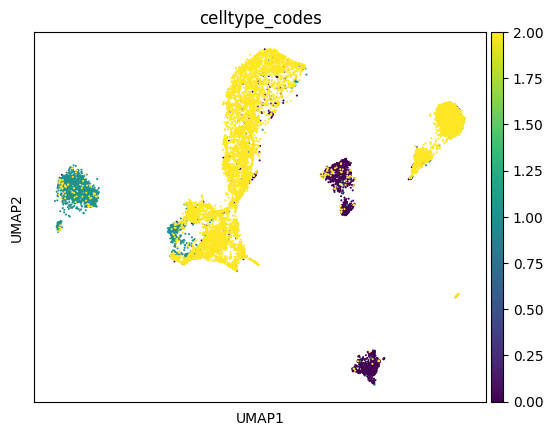

In [19]:
sc.pl.umap(adata, color='celltype_codes', legend_loc='on data')

In [20]:
metadata = pd.DataFrame(zip(adata.obs.index.values, adata.obs.celltype_codes.values, np.array(np.sum(np.array(adata.X.A), axis=1)).flatten()), columns=['barcode', 'cluster', 'nUMI'])

In [21]:
metadata.to_csv(os.path.join(data_folder, 'cside_preparations', filename, 'meta_data.csv'))